In [93]:
# https://lynnshin.tistory.com/46

# import splitfolders
# splitfolders.ratio('/home/piai/AI/cnn2/violence_data', output='/home/piai/AI/cnn2/real_dataset', seed=77, ratio=(0.7,0.3))

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

# from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

'''
Directory
    data - train - normal
                 ㄴ violence
         - val - normal
               ㄴ violence
'''
data_dir = './data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class_names

['normal', 'violence']

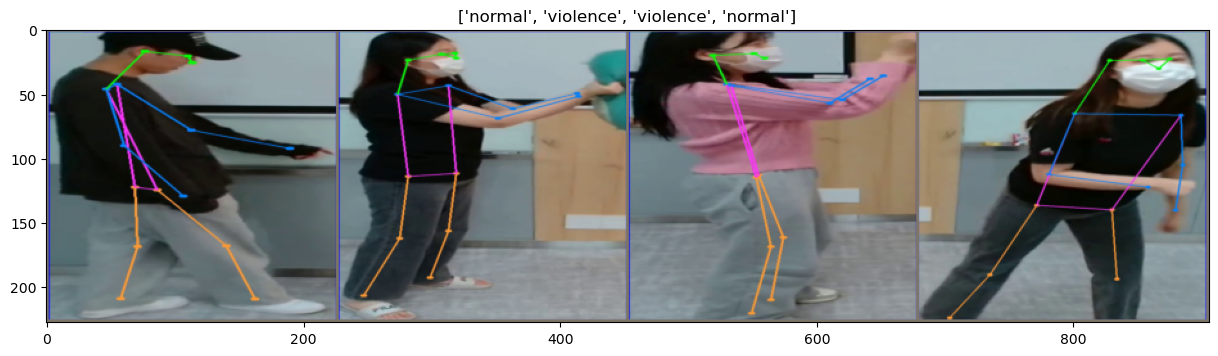

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15,15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, os.path.join('./cnnModels/weight/', '{0:0=2d}.pth'.format(epoch)))

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.mobilenet_v2(pretrained=True)
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.classifier[1] = nn.Linear(in_features=1280, out_features=2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.2275 Acc: 0.9241
val Loss: 0.1477 Acc: 0.9421

Epoch 1/9
----------
train Loss: 0.1508 Acc: 0.9472
val Loss: 0.1570 Acc: 0.9357

Epoch 2/9
----------
train Loss: 0.1425 Acc: 0.9485
val Loss: 0.0820 Acc: 0.9678

Epoch 3/9
----------
train Loss: 0.1429 Acc: 0.9505
val Loss: 0.0636 Acc: 0.9807

Epoch 4/9
----------
train Loss: 0.1343 Acc: 0.9541
val Loss: 0.0682 Acc: 0.9887

Epoch 5/9
----------
train Loss: 0.1538 Acc: 0.9545
val Loss: 0.0679 Acc: 0.9759

Epoch 6/9
----------
train Loss: 0.0818 Acc: 0.9716
val Loss: 0.0584 Acc: 0.9807

Epoch 7/9
----------
train Loss: 0.0734 Acc: 0.9761
val Loss: 0.0512 Acc: 0.9855

Epoch 8/9
----------
train Loss: 0.0705 Acc: 0.9785
val Loss: 0.0474 Acc: 0.9871

Epoch 9/9
----------
train Loss: 0.0557 Acc: 0.9789
val Loss: 0.0503 Acc: 0.9887

Training complete in 5m 34s
Best val Acc: 0.988746


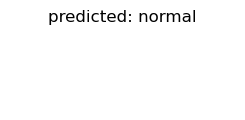

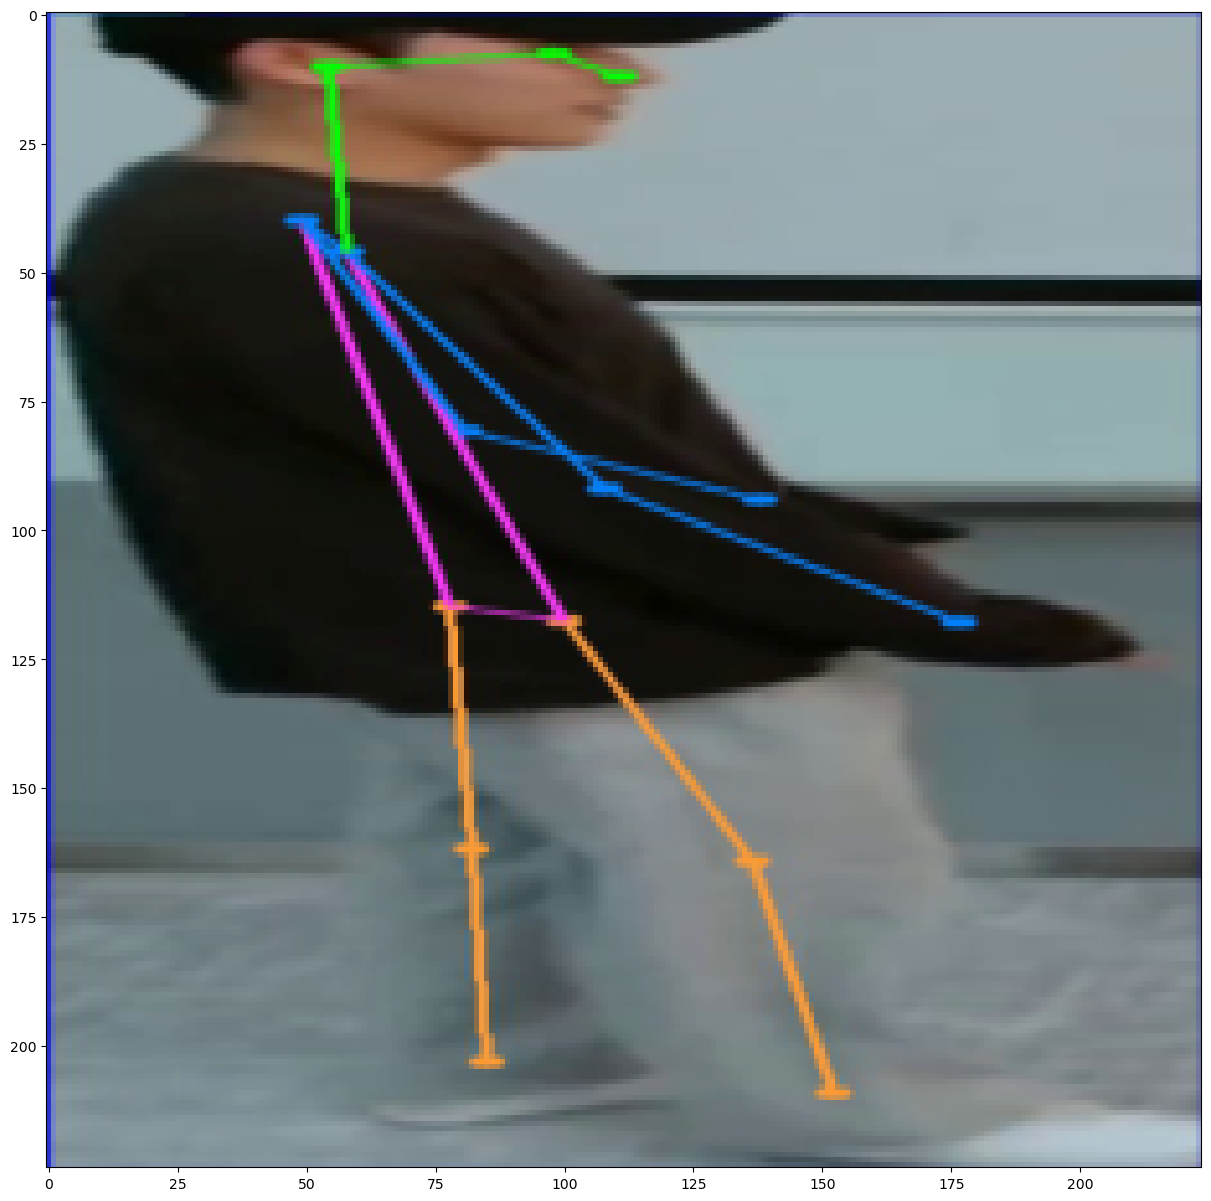

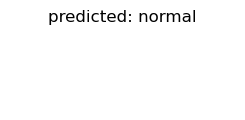

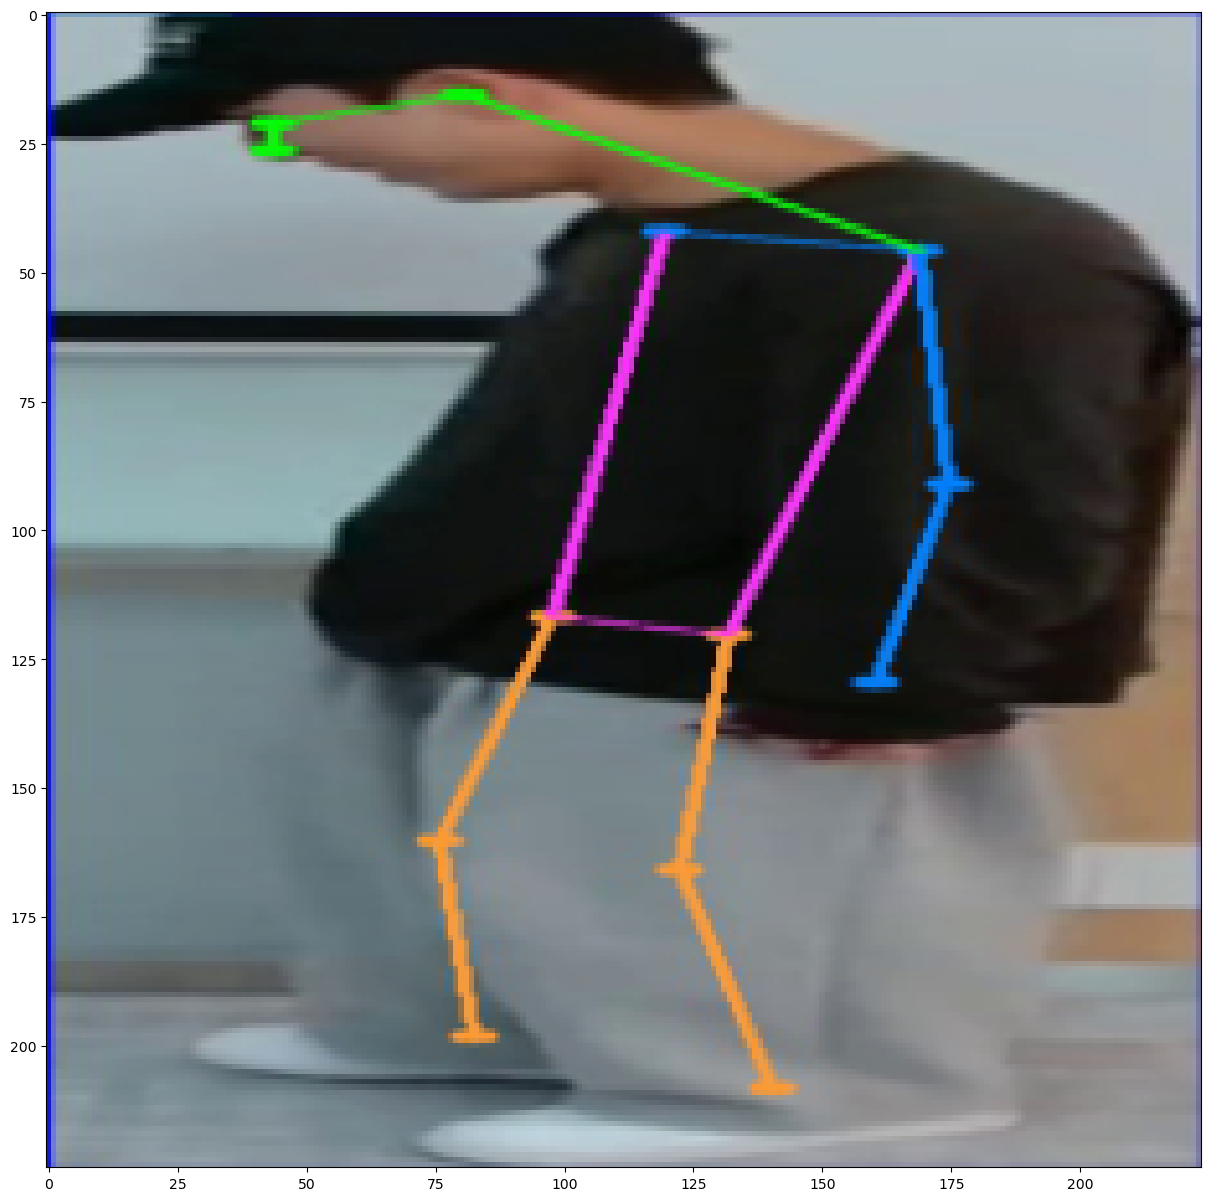

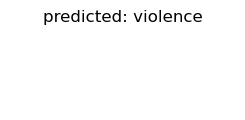

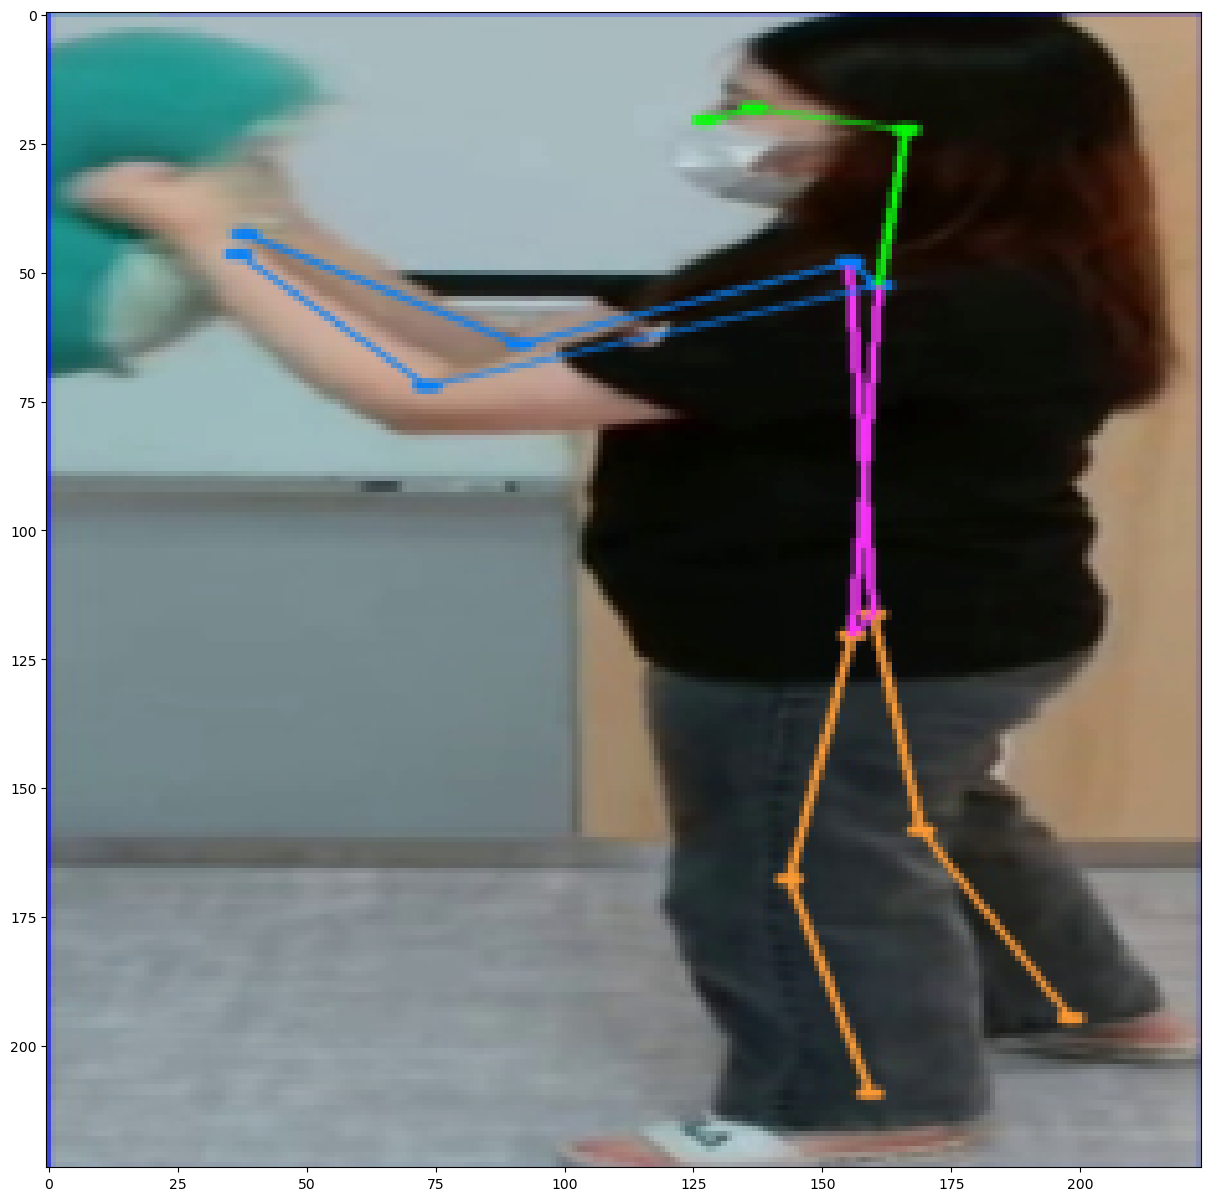

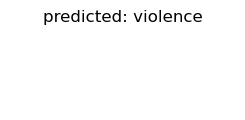

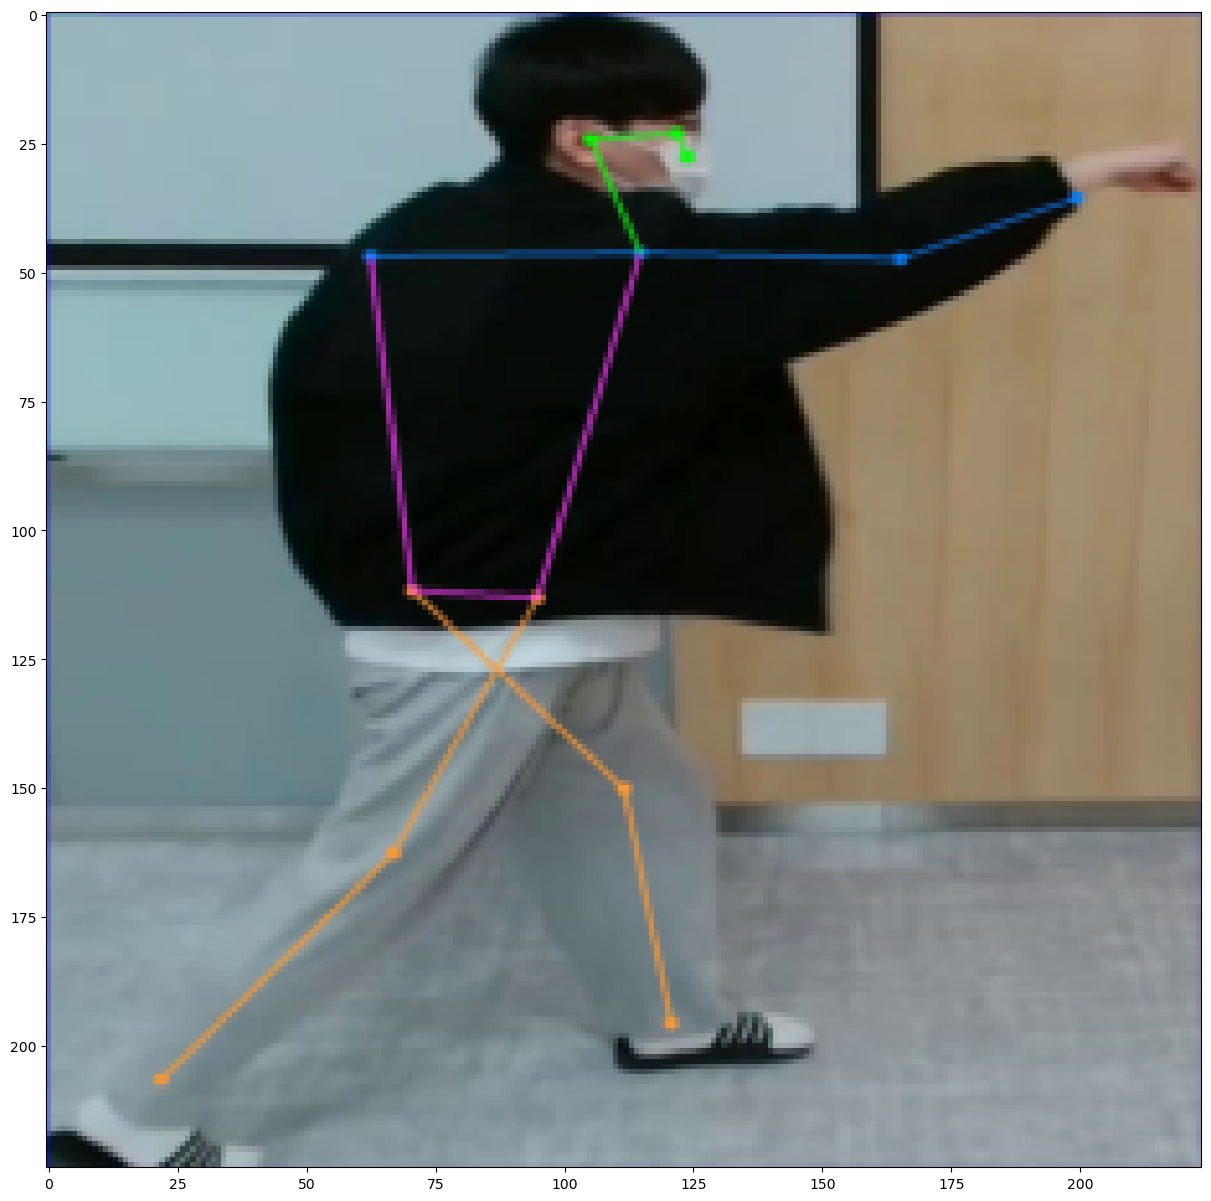

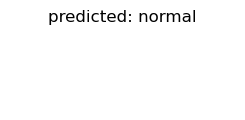

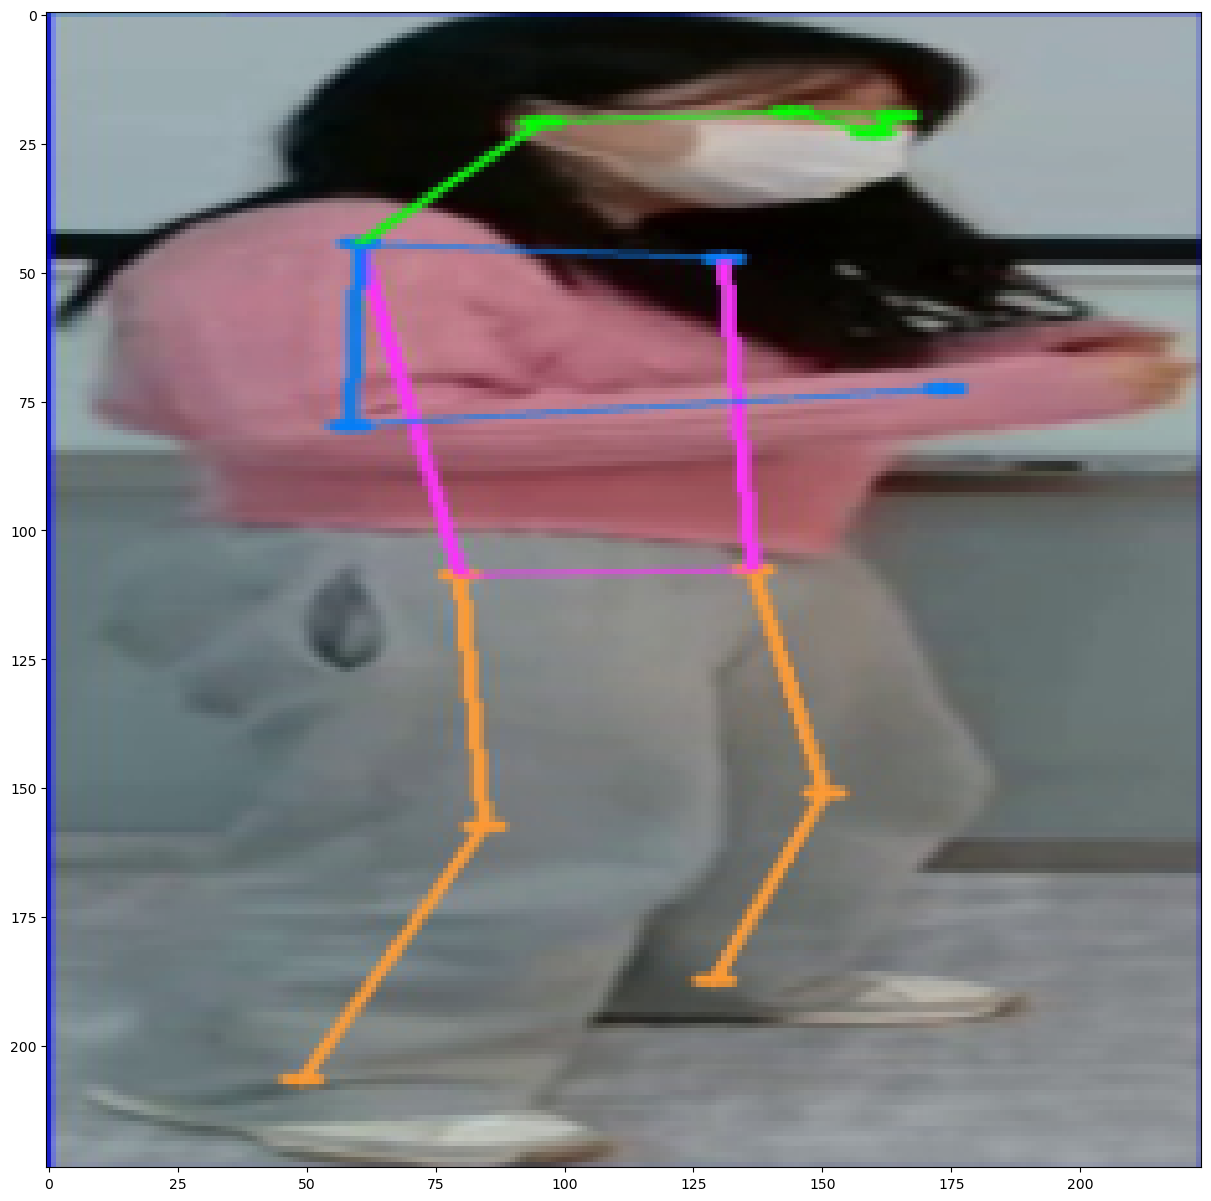

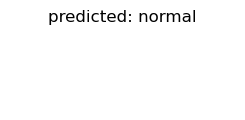

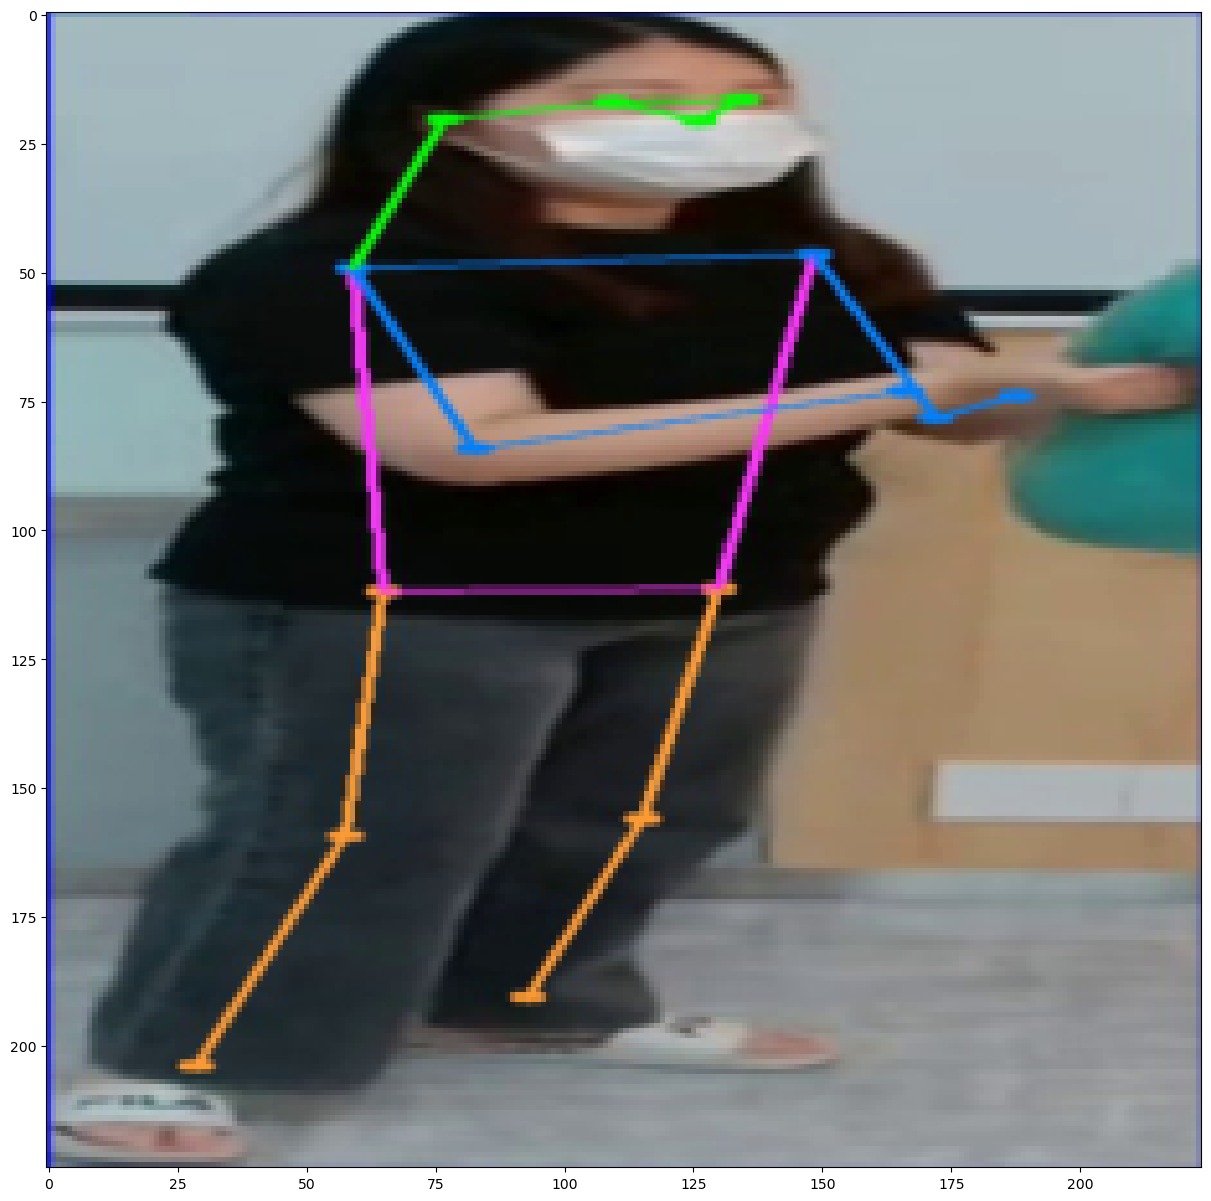

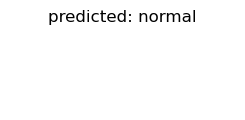

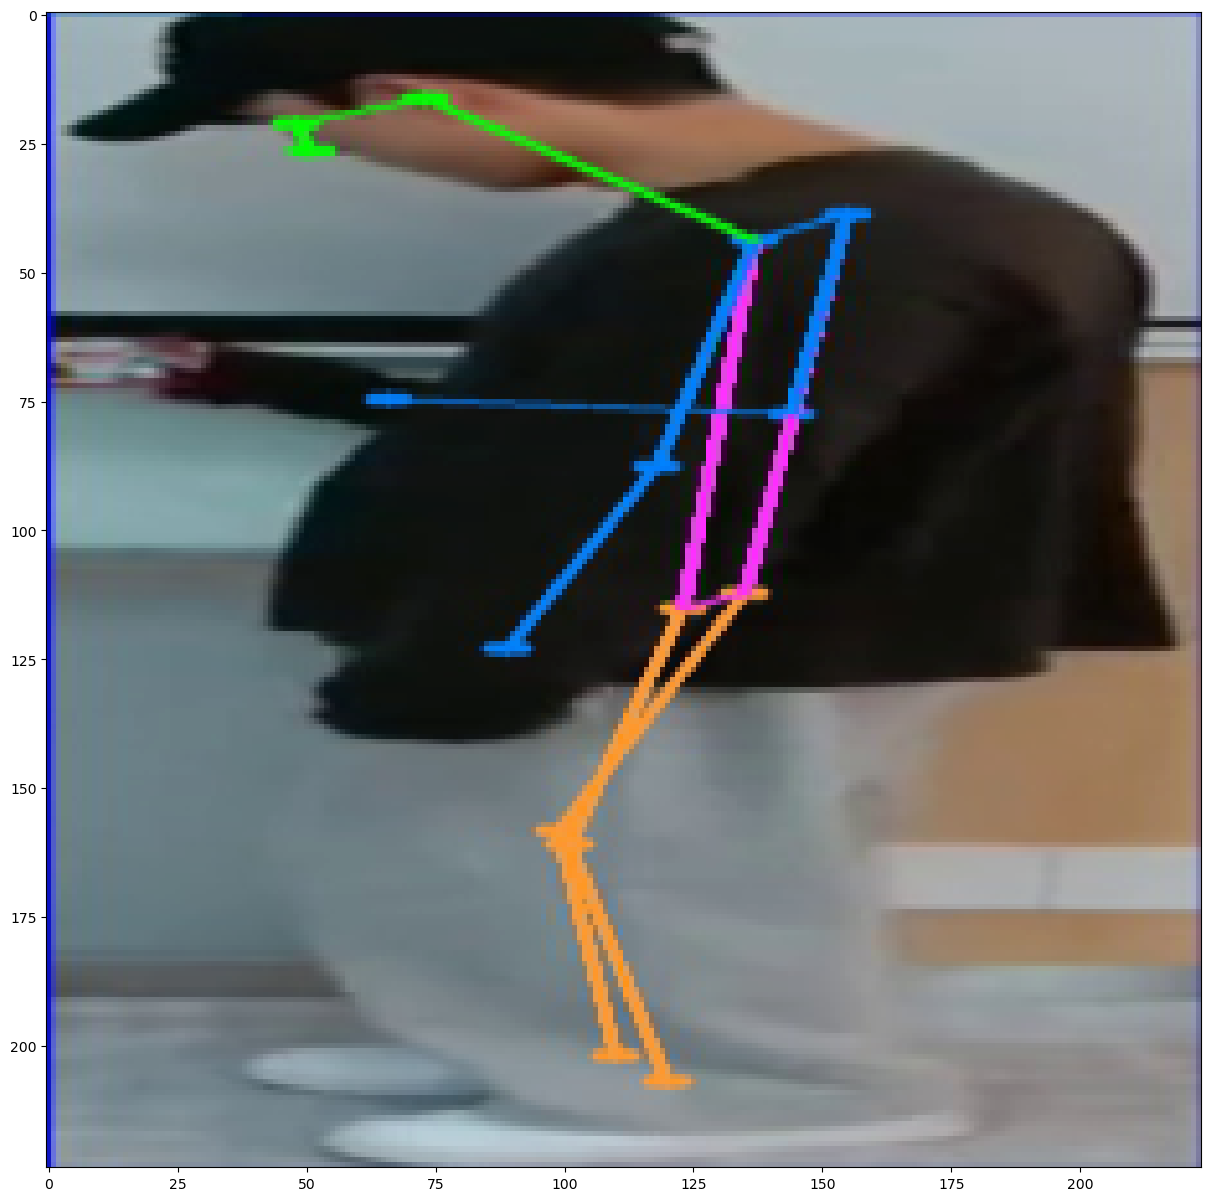

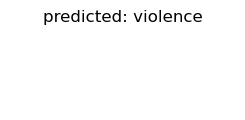

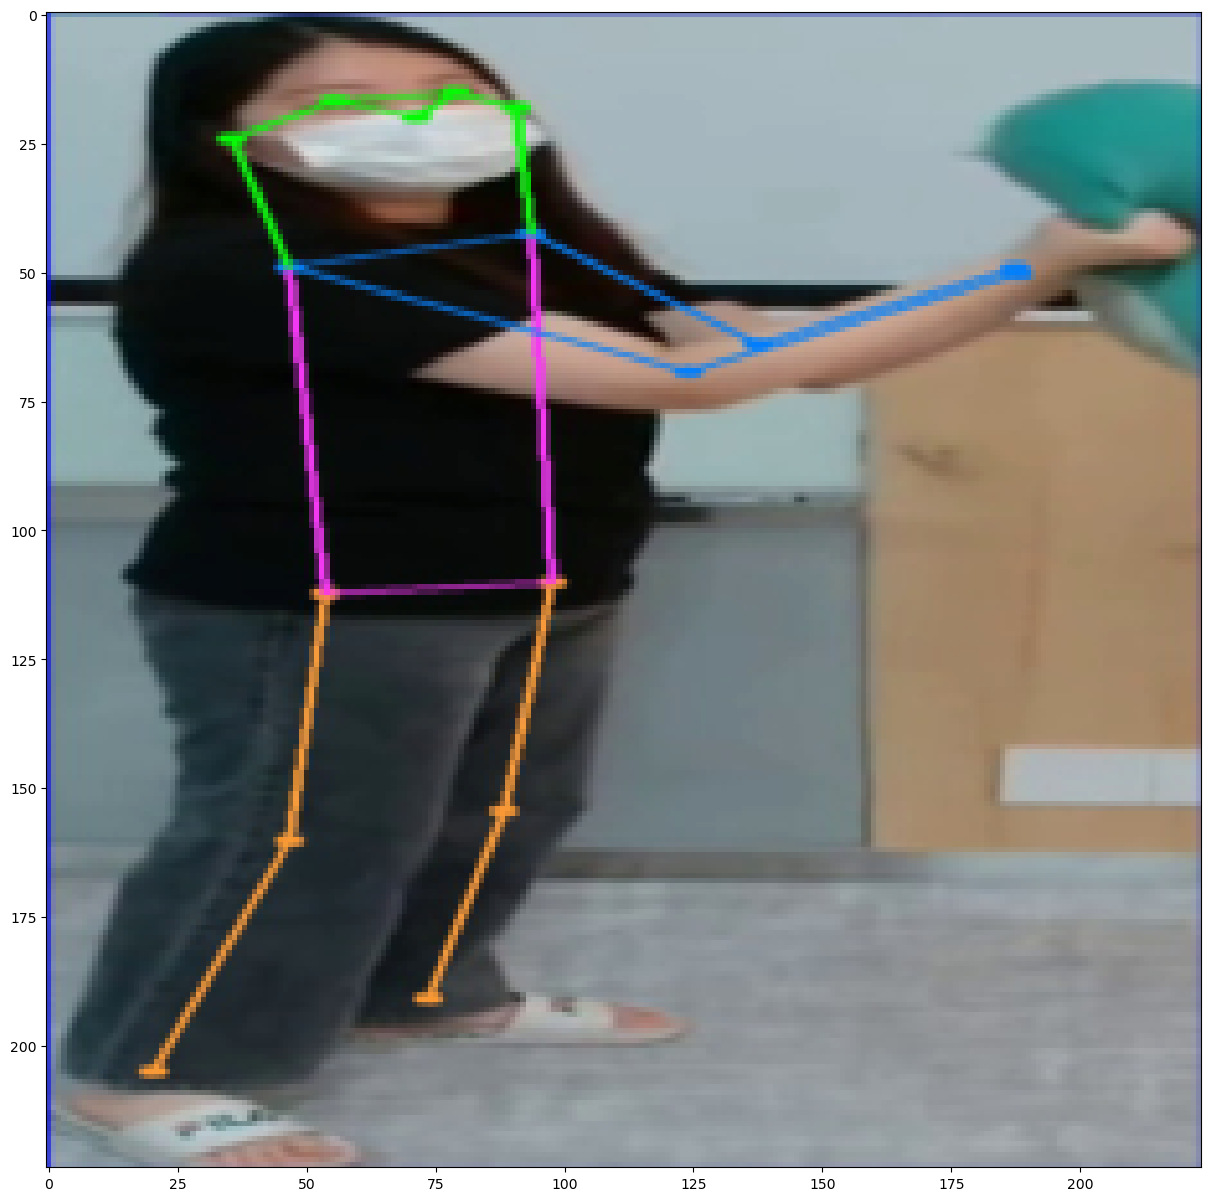

In [13]:
visualize_model(model_ft)

In [34]:
# import torch

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = torch.load("model_0416_best.pth", map_location=device)
# print(model)

AttributeError: Can't get attribute 'ConvBNReLU' on <module 'torchvision.models.mobilenet' from '/home/piai/anaconda3/envs/mldl_pytorch/lib/python3.8/site-packages/torchvision/models/mobilenet.py'>

In [8]:
PATH = './cnnModels/weight/04.pth'
model_pred = models.mobilenet_v2(pretrained=True)
model_pred.classifier[1] = nn.Linear(in_features=1280, out_features=2)
model_pred.load_state_dict(torch.load(PATH))
model_pred.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [15]:
from PIL import Image

device = torch.device("cpu")
model_pred.to(device)

def detect_violence(frame):
    predictions = []
    image_transforms = transforms.Compose([transforms.Resize(size=(244,244)), transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    f = Image.fromarray(frame)
    f = image_transforms(f)
    f = f.unsqueeze(0)
    prediction = model_pred(f)
    prediction = prediction.argmax()
    print(prediction)
    predictions.append(prediction.data)
    return predictions   


In [22]:
import numpy as np
from PIL import Image
import cv2

# img = Image.open('./data/val/normal/1781.jpg')
img = Image.open('./data/val/violence/685.jpg')
x = np.array(img)
print(x.shape)


(968, 429, 3)


In [23]:
jebal = detect_violence(x)

tensor(1)


In [21]:
jebal

[tensor(0)]